# Assignment - 9

## Import the Relevant Libraries

In [14]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2 
%matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

## Load the Dataset

CIFAR-10 dataset is loaded. It's $32 \times 32$ images with 50,000 images in the trainset and 10,000 in the test set.  

In [15]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Show the Data

One sample data is shown from each class to get and understanding of the underlying data visually. 

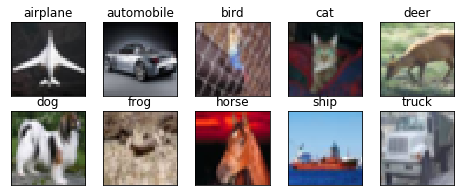

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

[2130, 9807, 4691, 2897, 5038, 5156, 9903, 6958, 265, 9069]


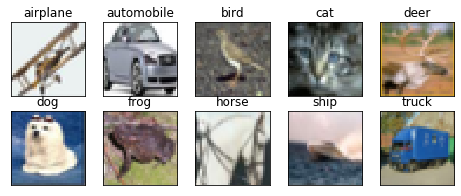

In [17]:
image_ids = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(test_labels[:]==i)[0]
    features_idx = test_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    image_ids[i] = idx[img_num]
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
print(image_ids)
plt.show()

## Image Normalization

The images are normalized for the complete training set. Thus, the mean and standard deviation of the training set is assumed to be the true mean and standard deviations. 

In [18]:
ntrain_features = train_features.astype('float32')/255
ntest_features = test_features.astype('float32')/255

X_mean = np.mean(ntrain_features, axis=0, keepdims=True)
X_std  = np.std(ntrain_features, axis=0, keepdims=True)
X_std  = np.clip(X_std, 1.0/255, 1.0)


ntrain_features = ntrain_features - X_mean
ntest_features  = ntest_features  - X_mean

ntrain_features = np.divide(ntrain_features, X_std)
ntest_features  = np.divide(ntest_features, X_std)

## Utility Methods

Two utility methods are generated:

1. Plot the model history of the loss and accuracy
2. Compute the final accuracy at the end of the runs

In [19]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['categorical_accuracy'])+1),model_history.history['categorical_accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_categorical_accuracy'])+1),model_history.history['val_categorical_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['categorical_accuracy'])+1),len(model_history.history['categorical_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [20]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Convert output to one hot vector format

In [21]:
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

print(test_labels.shape)

(10000, 10)


## Modified Model from 6A

1. Dropouts are pushed to after every convolutions. 
2. Dense networks are removed. 
3. Channels in convolutions were at 32 -> 128 -> 32 thus using significantly less number of parameters.

Almost 84% of accuracy was observed with almost no overfitting. Only 242K parameters were used. 

Raw code below is left without running and model has been backed up to `model.hdf5`

## Loading the model

In [23]:
from keras.models import load_model
model = load_model("model.hdf5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
__________

## Integration with GragCAM

The classes of objects picked up were *Cat*, *Deer*, *Dog*, *Horse* as there will be the greatest similarity across classes. 

Since, the images are small $32\times32$ generally all of the image is covered as part of the heatmap. Since, there are 4 classes of similar objects generally area beyond the face is given importance. 

[2130, 9807, 4691, 2897, 5038, 5156, 9903, 6958, 265, 9069]


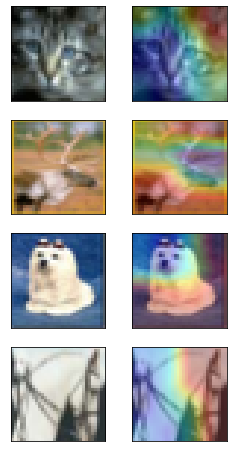

In [24]:
print(image_ids)
fig = plt.figure(figsize=(4,8))
ifig = 0
for i in [3, 4, 5, 7]:
    ii = image_ids[i]
    x = ntest_features[ii].reshape((1, 32, 32, 3))
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_27")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = test_features[ii]
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
    ifig += 1
    ax = fig.add_subplot(4, 2, ifig, xticks=[], yticks=[])
    plt.imshow(img)
    ifig += 1
    ax = fig.add_subplot(4, 2, ifig, xticks=[], yticks=[])
    plt.imshow(superimposed_img)
plt.show()

    

## Effect of Cutout

The cutout code was added to the image generator and training was carried out with learning scheduler. The learning did not improve the results drastically in terms of accuracy but gradcam output takes a larger outline of the body of the animal and contrast is stronger. For the horse the neck seems like a significant discerning parameter. 

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

(init_epoch, nepoch) = (0, 100)

mcp=ModelCheckpoint("model.{epoch:03d}-{val_loss:.2f}.hdf5", 
                    monitor='val_categorical_accuracy', verbose=1, save_best_only=True)


def scheduler(epoch, lr):
  return 0.001 * 1/(1 + epoch)

import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


datagen = ImageDataGenerator(
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False ,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True)
)


# train the model
start = time.time()

model_info = model.fit_generator(datagen.flow(ntrain_features, train_labels, batch_size = 128),
                                 epochs = nepoch, steps_per_epoch = 78,
                                 validation_data = (ntest_features, test_labels), verbose=1, 
                                 callbacks=[LearningRateScheduler(scheduler), mcp])
end = time.time()

Epoch 1/100
77/78 [============================>.] - ETA: 0s - loss: 0.2114 - categorical_accuracy: 0.5966

KeyboardInterrupt: 

In [25]:
model = load_model("model1.hdf5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
__________

[2130, 9807, 4691, 2897, 5038, 5156, 9903, 6958, 265, 9069]


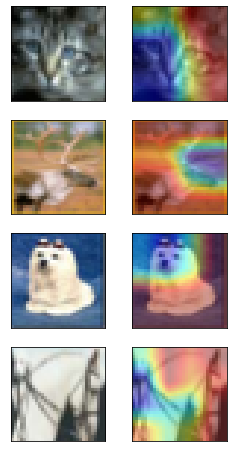

In [26]:
print(image_ids)
fig = plt.figure(figsize=(4,8))
ifig = 0
for i in [3, 4, 5, 7]:
    ii = image_ids[i]
    x = ntest_features[ii].reshape((1, 32, 32, 3))
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_27")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = test_features[ii]
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ifig += 1
    ax = fig.add_subplot(4, 2, ifig, xticks=[], yticks=[])
    plt.imshow(img)
    ifig += 1
    ax = fig.add_subplot(4, 2, ifig, xticks=[], yticks=[])
    plt.imshow(superimposed_img)
plt.show()

    